# Self-Driving Car Engineer Nanodegree
## Deep Learning
## Project: Behavioral Cloning

In this notebook, I implement some strategies based on deep neural networks and convolutional neural networks (convNets) to clone driving behavior using the Udacity Simulator. I used Keras as a main framework to develop the pipeline.
The general output of the pipeline is steering control of the car, that actually, it is control by itself. Well, use neural networks to learn the correct path.

In [1]:
# Importing useful packages
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential, Model
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import csv
import os
import copy

Using TensorFlow backend.



## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- 'features' is a 4D array containing raw pixel data of car's cameras
- 'y_train' is a 1D array containing the stering value

In [2]:
CORRECTION = 0.25 # Correction factor for stearing angles
DOWN_LIMIT = 20 # Down Horizontal limits to crop dataset
BATCH_SIZE = 128 # Batch size for training
UP_LIMIT = 65 # Up Horizontal limits to crop dataset
EPOCHS = 25 # NUmber of epochs for traings process

### Load the dataset

In [3]:
def load_dataset(data_paths, csv_name="driving_log.csv"):
    data = []
    for idx_path, data_path in enumerate(data_paths):
        data_path = os.path.join(data_path, csv_name)
        with open(data_path) as csvfile:
            reader = csv.reader(csvfile)
            for idx, line in enumerate(reader):
                if idx:
                    data.append({
                        "img_c":line[0],
                        "img_l":line[1],
                        "img_r":line[2],
                        "steering": float(line[3]),
                        })
            print("From .... {}: {} samples".format(data_paths[idx_path][-30:], idx))
    return data

In [4]:
# Define paths 
dataset_paths = [
    "self-driving-data-capture/track_1(1)",
    "self-driving-data-capture/track_1(2)",
    "self-driving-data-capture/track_2(1)",
    "self-driving-data-capture/track_2(2)"
    ]

# Load dataset
data = load_dataset(dataset_paths,  "driving_log.csv")
data = shuffle(data)

# Separate samples for training and testing process
train_samples, validation_samples = train_test_split(data, test_size=0.2)

From .... riving-data-capture/track_1(1): 6623 samples
From .... riving-data-capture/track_1(2): 6007 samples
From .... riving-data-capture/track_2(1): 9450 samples
From .... riving-data-capture/track_2(2): 7027 samples



### Basic Summary of the Data Set

To provide the basic summary of the Data Set, I used Python to create a dictionary.


In [5]:
def plot_data_distribution(y_data, scfc=30, graph_name="", save_name=None):
    plt.figure(figsize=(15,5))
    plt.hist(y_data, density=False, bins= [bin/scfc for bin in range(-scfc, scfc, 1)], facecolor='black', alpha=0.75)
    plt.xlabel('Angle (steering)')
    plt.ylabel('Data Quantity')
    plt.title(graph_name)
    plt.grid(True)
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

Number of Dataset samples: 29107
Number of training samples: 23285
Number of testing samples: 5822


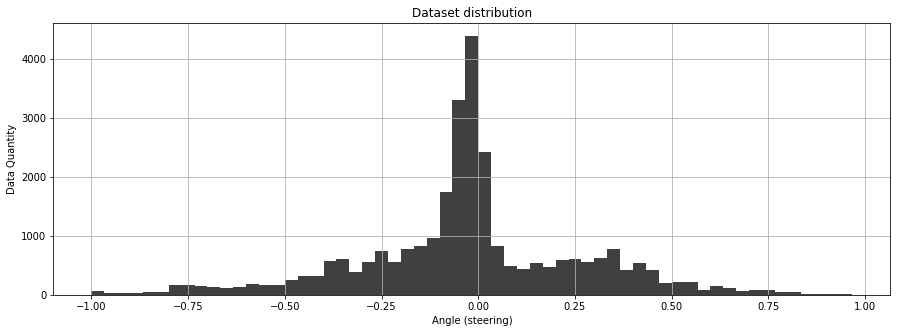

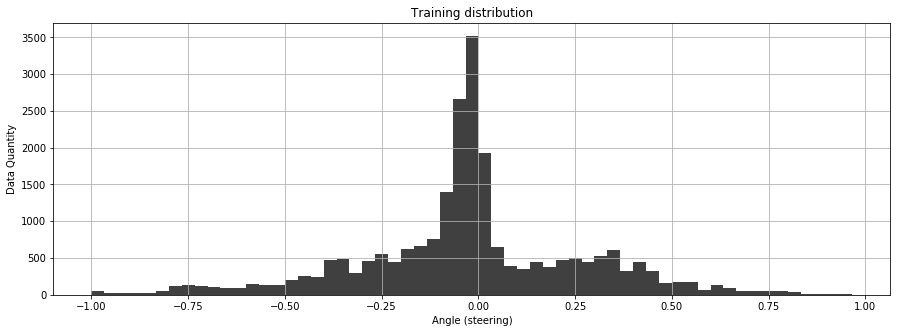

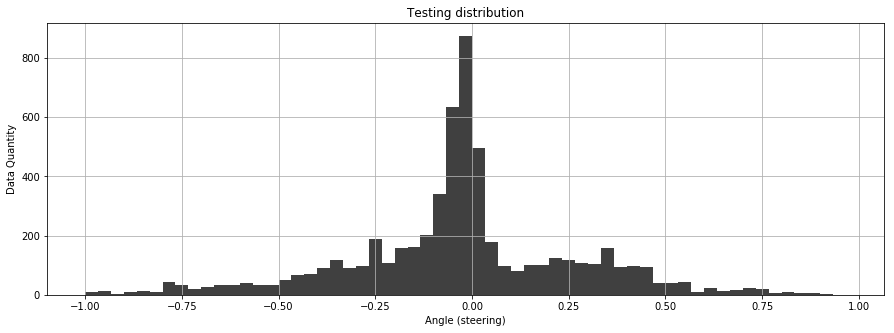

In [6]:
# Print dataset information
print("Number of Dataset samples: {}".format(len(data))) # Number of training examples
print("Number of training samples: {}".format(len(train_samples))) # Number of training examples
print("Number of testing samples: {}".format(len(validation_samples))) # Number of testing examples

# Plot dataset distribution
y_data_raw = np.asarray([data[idx]["steering"] for idx in range(len(data))])
plot_data_distribution(y_data_raw, scfc=30, graph_name="Dataset distribution", save_name="writeup_files/dataset_stee_angles.png")

# Plot dataset distribution
y_train_raw = np.asarray([train_samples[idx]["steering"] for idx in range(len(train_samples))])
plot_data_distribution(y_train_raw, scfc=30, graph_name="Training distribution",  save_name="writeup_files/training_stee_angles.png")

# Plot dataset distribution
y_test_raw = np.asarray([validation_samples[idx]["steering"] for idx in range(len(validation_samples))])
plot_data_distribution(y_test_raw, scfc=30, graph_name="Testing distribution",  save_name="writeup_files/testing_stee_angles.png")

In [7]:
def generator(samples, batch_size=32, angle_fc = 0.2):
    
    batch_size_org = batch_size
    batch_size = int(np.ceil(batch_size/6))
    
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []; angles = []
            
            # Read image and steering angle
            for batch_sample in batch_samples:
                                                    
                # Central camera
                img_c = cv2.cvtColor(cv2.imread(batch_sample["img_c"]), cv2.COLOR_BGR2RGB) 
                ang_c =  batch_sample["steering"]
                
                # Left camera
                img_l = cv2.cvtColor(cv2.imread(batch_sample["img_l"]), cv2.COLOR_BGR2RGB)
                ang_l =  batch_sample["steering"] + angle_fc

                # Right camera
                img_r = cv2.cvtColor(cv2.imread(batch_sample["img_r"]), cv2.COLOR_BGR2RGB)
                ang_r =  batch_sample["steering"] - angle_fc

                # Fliped Left camera
                img_lf = cv2.flip(img_l, 1)
                ang_lf = -ang_l

                # Fliped Right camera
                img_rf = cv2.flip(img_r, 1)
                ang_rf = -ang_r

                # Fliped center camera
                img_cf = cv2.flip(img_c, 1)
                ang_cf = -ang_c 

                images.extend((img_c, img_l, img_r, img_cf, img_lf, img_rf))
                angles.extend((ang_c, ang_l, ang_r, ang_cf, ang_lf, ang_rf))
                      
            images, angles = shuffle(images, angles)
                    
            # trim image to only see section with road
            X_train = np.array(images[:32])
            y_train = np.array(angles[:32])
                        
            # Return batch
            yield shuffle(X_train, y_train)

In [8]:
# Create data generators
train_generator = generator(train_samples, BATCH_SIZE, CORRECTION)
validation_generator = generator(validation_samples, BATCH_SIZE, CORRECTION)


## Step 2: Design and Test a Model Architecture

Find below the design and the implementation of a deep learning model that clone the driving of a car. Trained and tested with data taken using the Udacity Simulator.
A solid starting point is use the LeNet-5 implementation shown in the classroom. Basically, I changed the number of class and some layers, but eventually is the same architecture.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.


### Model Architecture


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.


In [9]:
model = Sequential()

# # Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x/255.) - 0.5, input_shape=(160, 320, 3)))

# # trim image to only see section with road
model.add(Cropping2D(cropping=((DOWN_LIMIT, UP_LIMIT),(0, 0))))

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, 3, 3, activation="relu"))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, 3, 3, activation="relu"))

# model.add(MaxPooling2D())

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100, activation="relu"))

#Adding a dropout layer to avoid overfitting. Here we are have given the dropout 
# rate as 25% after first fully connected layer
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50, activation="relu"))

#layer 8- fully connected layer 1
model.add(Dense(10, activation="relu"))

#layer 9- fully connected layer 1
#here the final layer will contain one value as this is a regression problem and not classification
model.add(Dense(1))

# the output is the steering angle using mean squared error loss function is the right choice 
# for this regression problem adam optimizer is used here
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="mse", optimizer=optimizer)
history_object  = model.fit_generator(
        train_generator, 
        steps_per_epoch=math.ceil(len(train_samples*6)/BATCH_SIZE), 
        validation_data=validation_generator, 
        validation_steps=math.ceil(len(validation_samples)/BATCH_SIZE), 
        epochs=EPOCHS, 
        verbose=1)

# Save the model whe n finish
model.save('model/behavioral_model.h5')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


Epoch 1/25
1092/1092 [==============================] - 451s 413ms/step - loss: 0.0632 - val_loss: 0.0458
Epoch 2/25
1092/1092 [==============================] - 150s 137ms/step - loss: 0.0426 - val_loss: 0.0360
Epoch 3/25
1092/1092 [==============================] - 88s 81ms/step - loss: 0.0369 - val_loss: 0.0362
Epoch 4/25
1092/1092 [==============================] - 88s 81ms/step - loss: 0.0332 - val_loss: 0.0300
Epoch 5/25
1092/1092 [==============================] - 88s 81ms/step - loss: 0.0311 - val_loss: 0.0276
Epoch 6/25
1092/1092 [==============================] - 84s 77ms/step - loss: 0.0287 - val_loss: 0.0260
Epoch 7/25
1092/1092 [==============================] - 72s 66ms/step - loss: 0.0279 - val_loss: 0.0268
Epoch 8/25
1092/1092 [==============================] - 72s 66ms/step - loss: 0.0265 - val_loss: 0.0250
Epoch 9/25
1092/1092 [==============================] - 71s 65ms/step - loss: 0.0253 - val_loss: 0.0266
Epoch 10/25
1092/1092 [==============================] - 71s

## Plot Testing Results

In [10]:
def plot_training_history(history_object, fig_size=(30,40), save_name=None):
    plt.figure(figsize=fig_size)

    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('Mean squared error loss model')
    plt.ylabel('Mean squared error loss model')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    plt.grid(True)
    if save_name is not None:
            plt.savefig(save_name)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

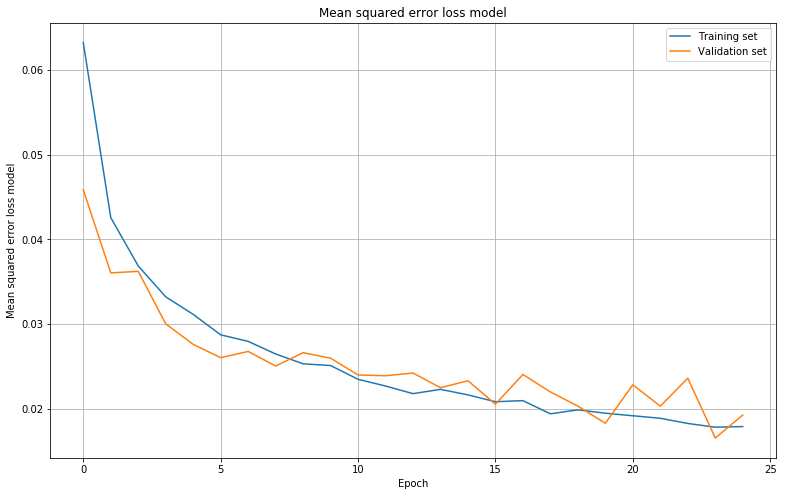

In [11]:
# keras method to print the model summary
model.summary()

# Plot training history
plot_training_history(history_object, fig_size=(13,8), save_name="writeup_files/training_loss_graph.png")


### Run Simulation Enviroment, Model and Other Utils

NOTE: If you recently trained a model you must restart the kernel to free memory


In [12]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [1]:
def setClipboardData(data):
    p = subprocess.Popen(['xclip','-selection','clipboard'], stdin=subprocess.PIPE)
    p.stdin.write(data)
    p.stdin.close()
    retcode = p.wait()

In [2]:
def create_model_result_video(src_path, dst_path="", save_name="model_results_cam_c.mp4", 
    fps=30., video_size=(360, 160)):

    # Define the codec and format and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec H264, format MP4
    video_name = os.path.join(dst_path, save_name) # File name and format
    video_out = cv2.VideoWriter(video_name, fourcc, fps, video_size) # Video recorder variable

    for index, filename in enumerate(sorted(os.listdir(src_path))):
        
        # Read image and write it to video
        img_path = os.path.join(src_path, filename)
        img = cv2.imread(img_path)
        video_out.write(cv2.resize(img, video_size))

    # Release video variable memory
    video_out.release()


In [3]:
from IPython.display import clear_output
from multiprocessing import Pool 
import subprocess
import os

def run_process(process):                                                             
    os.system('{}'.format(process))

In [4]:
# Create Video from desktop
video_name = "behavioral_driving_stg{}_test{}.mp4".format(1, 1)
command = "ffmpeg -video_size {}x{} -framerate 25 -f x11grab -i :0.0+100,200 {}".format(
    1000, 650, os.path.join(os.getcwd(), "model/video_results", video_name))
print(command); setClipboardData(command.encode())

ffmpeg -video_size 1000x650 -framerate 25 -f x11grab -i :0.0+100,200 /home/kiwivision/Documents/JJ_CarND/CarND-Behavioral-Cloning-P3/model/video_results/behavioral_driving_stg1_test1.mp4


In [5]:
# Create gif from videovideo_name, 
video_name = "stage_1_03312019_img_r"
command = "ffmpeg -i {}.mp4 -ss 15 -t 20 {}.gif -hide_banner".format(video_name, video_name)
print(command); setClipboardData(command.encode())

ffmpeg -i stage_1_03312019_img_r.mp4 -ss 15 -t 20 stage_1_03312019_img_r.gif -hide_banner


In [7]:
# Run simulator and socket to drive autonomously
try:
    time_for_server = 10
    processes = (
        "clear && {}".format(os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64")),
        "clear && termdown {} && clear && python3 {} {} {}".format(
            time_for_server,
            os.path.join(os.getcwd(), "drive.py"), 
            os.path.join(os.getcwd(), "model", "behavioral_model.h5"), 
            os.path.join(os.getcwd(), "model", "image_results ")))
    print(processes[0])
    print(processes[1])
    pool = Pool(processes=len(processes))                                                        
    pool.map(run_process, processes)
except:
    print("Process has finished")

clear && /home/kiwivision/Documents/JJ_CarND/CarND-Behavioral-Cloning-P3/beta_simulator_linux/beta_simulator.x86_64
clear && termdown 10 && clear && python3 /home/kiwivision/Documents/JJ_CarND/CarND-Behavioral-Cloning-P3/drive.py /home/kiwivision/Documents/JJ_CarND/CarND-Behavioral-Cloning-P3/model/behavioral_model.h5 /home/kiwivision/Documents/JJ_CarND/CarND-Behavioral-Cloning-P3/model/image_results 
Process has finished


Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
# Run only simulation environment
command = os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64")
os.system('{}'.format(command)) 
print(command)

In [8]:
# Create model's results video   
create_model_result_video(src_path = os.path.join(os.getcwd(), "model", "image_results"), 
                          dst_path = os.path.join(os.getcwd(), "model", "video_results"),
                          video_size = (360, 160))

NameError: name 'cv2' is not defined